In [1]:
!git clone https://deepraj1729@bitbucket.org/jadslim/german-traffic-signs.git 

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import pickle
import pandas as pd
import random
import cv2
import requests
from PIL import Image


Using TensorFlow backend.


In [3]:
np.random.seed(0)

In [4]:
with open("german-traffic-signs/train.p","rb") as f:
    train_data = pickle.load(f)

with open("german-traffic-signs/valid.p","rb") as f:
    val_data = pickle.load(f)

with open("german-traffic-signs/test.p","rb") as f:
    test_data = pickle.load(f)


In [5]:
x_train,y_train = train_data['features'],train_data['labels']
x_val,y_val = val_data['features'],val_data['labels']
x_test,y_test = test_data['features'],test_data['labels']

In [6]:
assert(x_train.shape[0]==y_train.shape[0]), "The number of training images in not equal to the number of training labels"
assert(x_val.shape[0]==y_val.shape[0]), "The number of validating images in not equal to the number of validating labels"
assert(x_test.shape[0]==y_test.shape[0]), "The number of testing images in not equal to the number of testing labels"

In [7]:
df = pd.read_csv("german-traffic-signs/signnames.csv")

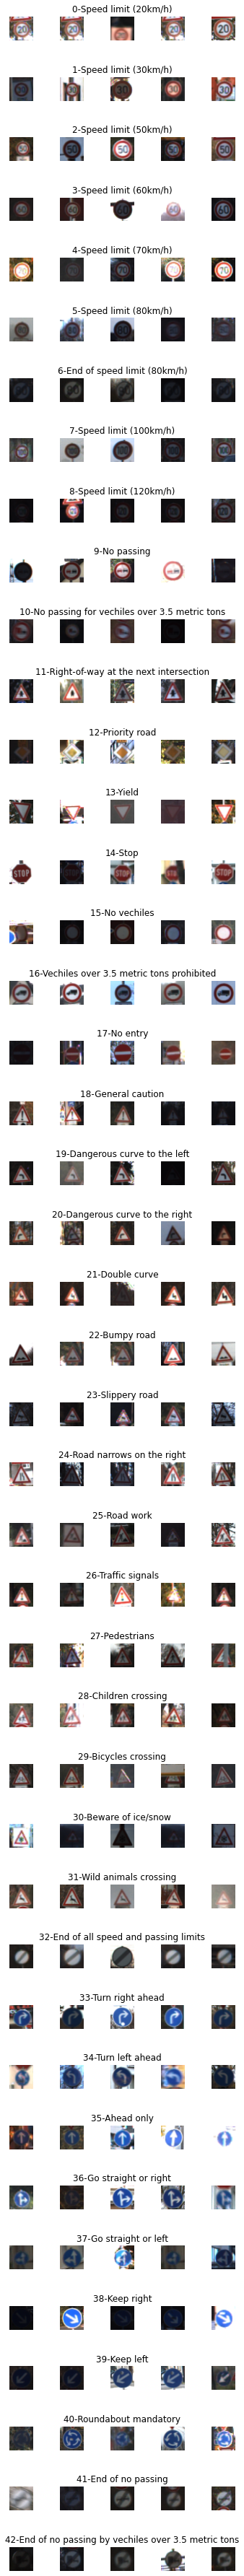

In [8]:
num_of_samples = []

cols= 5
num_of_classes = 43

fig,axs = plt.subplots(nrows=num_of_classes,ncols=cols,figsize = (5,50))
fig.tight_layout()

for i in range(cols):
    for j,row in df.iterrows():
        x_selected = x_train[y_train==j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)), :, :],cmap = plt.get_cmap('gray'))
        axs[j][i].axis('off')
        if i==2:
            axs[j][i].set_title(str(j)+"-"+row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


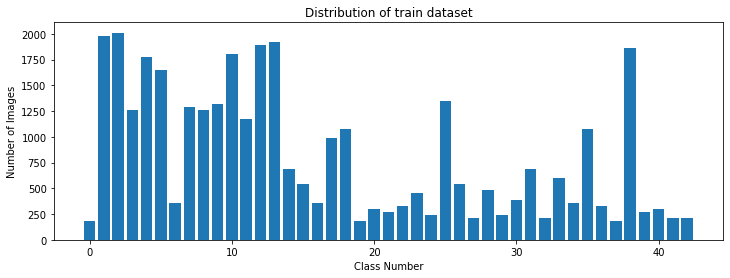

In [9]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_of_classes),num_of_samples)
plt.title("Distribution of train dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.show()

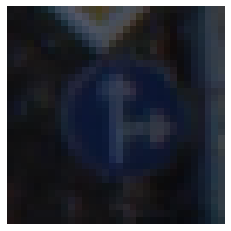

(32, 32, 3)
36


In [10]:
plt.imshow(x_train[1000])
plt.axis('off')
plt.show()
print(x_train[1000].shape)
print(y_train[1000])

In [11]:
def grayscale(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return gray

def equalize(img):
    equalimg = cv2.equalizeHist(img)
    return equalimg

(32, 32)


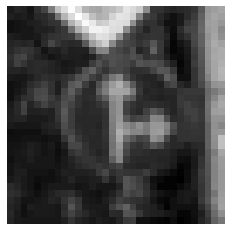

In [12]:
img = grayscale(x_train[1000])

plt.imshow(img,cmap='gray')
plt.axis('off')
print(img.shape)

(32, 32)


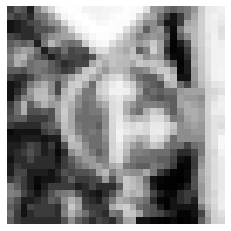

In [13]:
img = equalize(img)

plt.imshow(img,cmap='gray')
plt.axis('off')
print(img.shape)

In [14]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [15]:
x_train = np.array(list(map(preprocessing,x_train)))
x_val = np.array(list(map(preprocessing,x_val)))
x_test = np.array(list(map(preprocessing,x_test)))

(-0.5, 31.5, 31.5, -0.5)

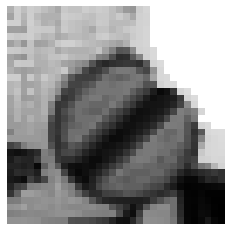

In [16]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)],cmap='gray')
plt.axis('off')

In [17]:
#train shape
num_of_train_images = x_train.shape[0]

#validation shape
num_of_val_images = x_val.shape[0]

#testing shape
num_of_test_images = x_test.shape[0]

#params
height = 32
width = 32
channels = 1

#reshape for CNN input
x_train = x_train.reshape(num_of_train_images,height,width,channels)
x_val = x_val.reshape(num_of_val_images,height,width,channels)
x_test = x_test.reshape(num_of_test_images,height,width,channels)

In [18]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(x_train)

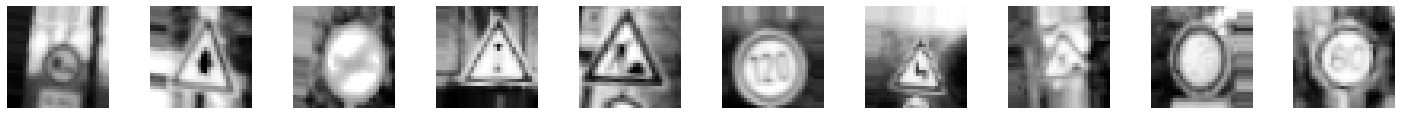

In [19]:
#Showing augmented images
batches = datagen.flow(x_train,y_train,batch_size=20)
x_batch,y_batch = next(batches)

fig,axs = plt.subplots(1,10,figsize= (20,5))
fig.tight_layout()

for i in range(10):
    axs[i].imshow(x_batch[i].reshape(32,32),cmap='gray')
    axs[i].axis('off')

In [20]:
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)
y_test = to_categorical(y_test,43)

In [25]:
def complex_Model():
    model = Sequential()
    model.add(Conv2D(60,(5,5),input_shape = (height,width,channels),activation='relu'))
    model.add(Conv2D(60,(5,5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(30,(3,3),activation='relu'))
    model.add(Conv2D(30,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43,activation='softmax'))

    #compile
    model.compile(Adam(lr = 0.001),loss='categorical_crossentropy',metrics = ['accuracy'])

    return model

In [26]:
model = complex_Model()

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

In [28]:
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=50),steps_per_epoch = 2000, epochs = 20 ,validation_data=(x_val,y_val),shuffle = 1)

Epoch 1/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.9099 - accuracy: 0.7334 - val_loss: 0.1003 - val_accuracy: 0.9712
Epoch 2/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.2254 - accuracy: 0.9309 - val_loss: 0.0638 - val_accuracy: 0.9814
Epoch 3/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1501 - accuracy: 0.9529 - val_loss: 0.0563 - val_accuracy: 0.9816
Epoch 4/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1196 - accuracy: 0.9628 - val_loss: 0.0292 - val_accuracy: 0.9923
Epoch 5/20
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1017 - accuracy: 0.9687 - val_loss: 0.0312 - val_accuracy: 0.9909
Epoch 6/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.0895 - accuracy: 0.9723 - val_loss: 0.0233 - val_accuracy: 0.9934
Epoch 7/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.0794 - accuracy: 0.9756 - val_loss: 0.0360 -

Text(0, 0.5, 'Loss')

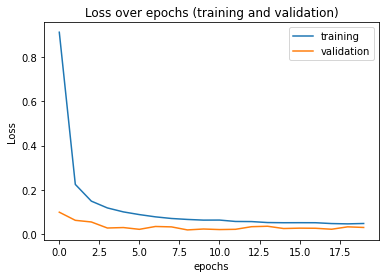

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss over epochs (training and validation)')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

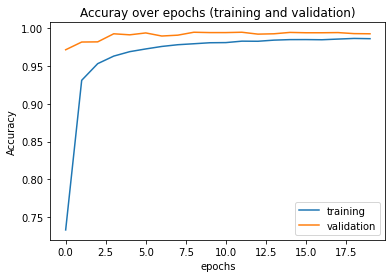

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuray over epochs (training and validation)')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [31]:
#Evaluate on test data
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test accuracy = ',score[1])

Test Score =  0.10044568017956264
Test accuracy =  0.9780681133270264


In [32]:
path = r"model.h5"
model.save(path)

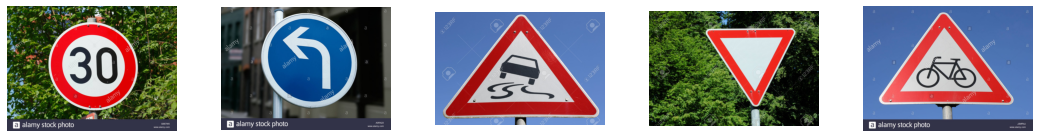

In [35]:
def getImg(url):
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    return img

def showImg(img):
    plt.imshow(img, cmap=plt.get_cmap('gray'))

def prepareImg(img):
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    return img

def predictImg(img):
    img = img.reshape(1, 32, 32, 1)
    #Test image
    print("Predicted sign: "+ str(model.predict_classes(img)))


urls = ["https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg",
        "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg",
        "https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg",
        "https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg",
        "https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"]



img1 = getImg(url=urls[0])
img2 = getImg(url=urls[1])
img3 = getImg(url=urls[2])
img4 = getImg(url=urls[3])
img5 = getImg(url=urls[4])

web_imgs = [img1,img2,img3,img4,img5]

fig,axs = plt.subplots(1,5,figsize= (15,10))
fig.tight_layout()

for i in range(5):
    axs[i].imshow(web_imgs[i],cmap='gray')
    axs[i].axis('off')

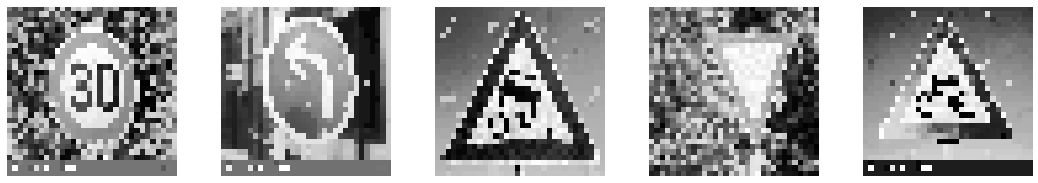

In [42]:
#Prepare image for feeding to trained CNN model

prep_img1 = prepareImg(img1)
prep_img2 = prepareImg(img2)
prep_img3 = prepareImg(img3)
prep_img4 = prepareImg(img4)
prep_img5 = prepareImg(img5)

prepared_imgs = [prep_img1,prep_img2,prep_img3,prep_img4,prep_img5]

fig,axs = plt.subplots(1,5,figsize= (15,10))
fig.tight_layout()

#Showing prepared images
for i in range(5):
    axs[i].imshow(prepared_imgs[i],cmap='gray')
    axs[i].axis('off')

In [43]:
#Prediction for each image
for i in range(5):
    predictImg(prepared_imgs[i])

Predicted sign: [1]
Predicted sign: [34]
Predicted sign: [23]
Predicted sign: [13]
Predicted sign: [24]


In [ ]:
#End of Notebook